<h3>Exploratory Data Analysis on Haberman Dataset</h3>

The dataset contains cases from a study between 1958-1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.

**Features**:
*   Age: Age of patient at time of operation
*   Year: Patient's year of operation (1900)
*   Nodes: Number of positive axillary nodes detected
*   Status: 1 = patient survived 5 years or longer after operation, 2 = patient died withinn 5 years of operation

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
files=files.upload()

Saving haberman.csv to haberman.csv


In [3]:
df = pd.read_csv('haberman.csv')
df.head()

,age,year,nodes,status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


<h3>(1) Basic Overview</h3>

In [4]:
print("No. of Data Points:", df.shape[0])
print("No. of Features:", df.shape[1])
print("\nUnique values:\n", df.nunique())

No. of Data Points: 306
No. of Features: 4

Unique values:
 age       49
year      12
nodes     31
status     2
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     306 non-null    int64
 1   year    306 non-null    int64
 2   nodes   306 non-null    int64
 3   status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [6]:
df.status.value_counts()

1    225
2     81
Name: status, dtype: int64

In [7]:
df.status.value_counts(normalize=True)

1    0.735294
2    0.264706
Name: status, dtype: float64

In [8]:
df.describe()

,age,year,nodes,status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


>**Observations:**
> 
>1.   There are 306 data points across 4 features (all integer data type with no null values).
2.   There are 2 classes for 'status', with an imbalanced distribution across the 2 classes, with 74% of data points having status of 1 and 26% having status of 2.
3. No. of nodes appears to have a very wide spread, with a min of 0 and max of 52. The median is 1 and at least 25% of patients have 0 nodes, indicating the presence of patients with very high no. of nodes.

<h3>(2) Overview: Correlation and Distribution</h3>

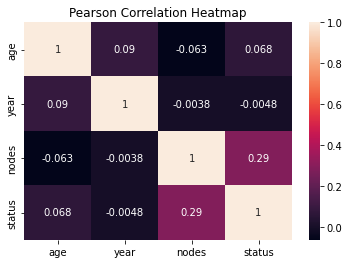

In [9]:
sns.heatmap(df.corr(), annot=True);
plt.title('Pearson Correlation Heatmap')
plt.show();

>**Observations:**
>
>No features have a strong correlation with status, except for nodes which has a small-to-moderate correlation with status.

Text(0.5, 1.02, 'Pair Plots by Status')

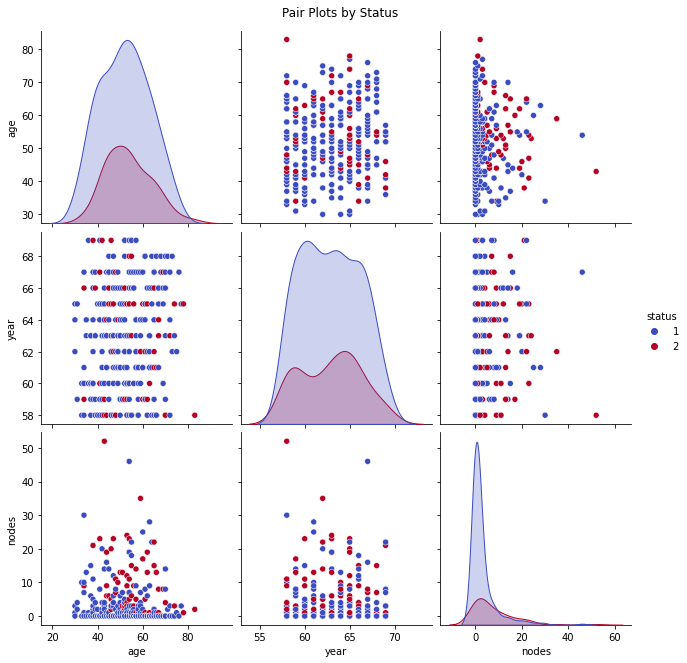

In [10]:
# sns.set_style("whitegrid");
g = sns.pairplot(df, hue="status", height=3, palette='coolwarm')
g.fig.suptitle("Pair Plots by Status", y=1.02) # y= height>1 to allocate spacing

>**Observations:**
>
>No obvious trend/relationship jumps out in identifying status of patients.

<h3>(3) No. of Cancer Nodes: Detailed Analysis</h3>

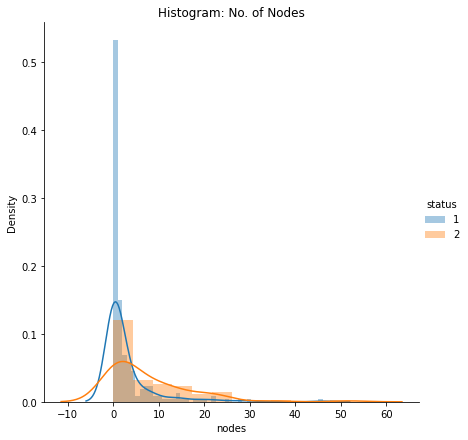

In [11]:
sns.FacetGrid(df, hue="status", height=6) \
   .map(sns.distplot, "nodes") \
   .add_legend();
plt.title('Histogram: No. of Nodes')
plt.show();

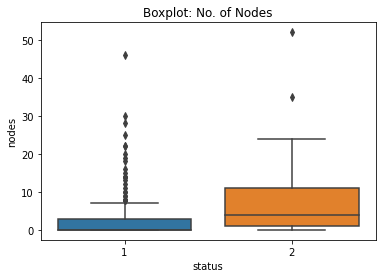

In [12]:
sns.boxplot(x='status',y='nodes', data=df)
plt.title('Boxplot: No. of Nodes')
plt.show()

In [13]:
# as the range of possible no. of nodes is wide, create new categorical column with 3 groups for nodes to simplify visualisation
df['nodes_group'] = df['nodes'].apply(lambda x: '0' if x == 0 else ('1-4' if x<5 else '>4'))
df.head()

,age,year,nodes,status,nodes_group
0,30,64,1,1,1-4
1,30,62,3,1,1-4
2,30,65,0,1,0
3,31,59,2,1,1-4
4,31,65,4,1,1-4


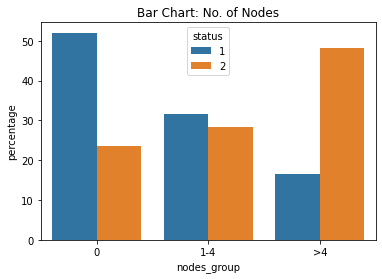

In [14]:
# as the no. of data points for status of 1 is close to 3x more than the no. of points for status of 2, use percentage instead of actual counts
temp_nodes = (df.groupby(['status'])['nodes_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('nodes_group'))
p = sns.barplot(x="nodes_group", y="percentage", hue="status", data=temp_nodes)
plt.title('Bar Chart: No. of Nodes')
plt.show();

In [15]:
df.groupby(['status']).agg({'nodes':['mean','median','std','mad','min','max','count',pd.Series.mode]})
# last column represents mode (referred here: https://github.com/pandas-dev/pandas/issues/11562)

nodes                                              
            mean median       std       mad min max count mode
status                                                        
1       2.791111      0  5.870318  3.533630   0  46   225    0
2       7.456790      4  9.185654  6.846822   0  52    81    0

>**Observations for Nodes (Part 1):**
>
>1. The overall distribution is skewed right (as the no. of nodes has a natural boundary of 0).
2. Patients with status of 1 tend to have less no. of nodes, with at least 50% of patients having 0 nodes. Its distribution is centred around 0, although the boxplot indicates plenty of outliers, with mean of 2.8 vs median of 0.
3. Patients with status of 2 tend to have more no. of nodes, with at least 70% of patients having at least 1 node. However, its distribution is centred close to 0, albeit with higher spread compared to status of 1. The boxplot indicates presence of outliers, with mean of 7.5 vs median of 4.
4. As nodes can provide some indication on the status of the patient, let's analyze further using CDFs.

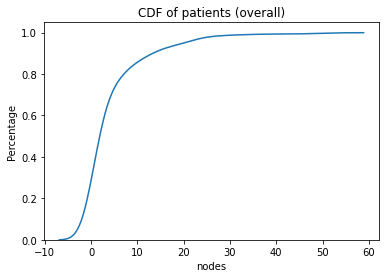

In [16]:
sns.kdeplot(df['nodes'], cumulative=True);
plt.ylabel('Percentage')
plt.title('CDF of patients (overall)')
plt.show();

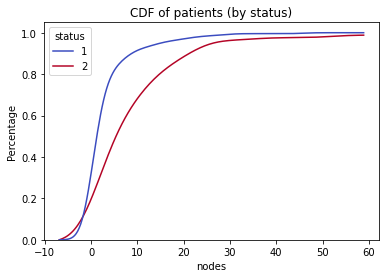

In [17]:
sns.kdeplot(data = df, x='nodes', hue='status',cumulative=True, common_norm=False, common_grid=True, palette='coolwarm');
plt.ylabel('Percentage')
plt.title('CDF of patients (by status)')
plt.show();

>**Observations for Nodes (Part 2):**
>
>1. As expected, the CDFs for patients of status 1 and 2 have differences, with patients of status 1 having lower no. of nodes.
2. Example 1: The probability of a patient of status 1 having 5 nodes or less is around 80%, whereas the corresponding probability for a patient of status 2 is around 50%. 
3. Exmaple 2: The probability of a patient of status 1 having 0 nodes is around 25%, verses 20% for a patient of status 2.
4. No. of nodes provides some insights in identifying status of patient.

<h3>(4) Patient Age: Detailed Analysis</h3>

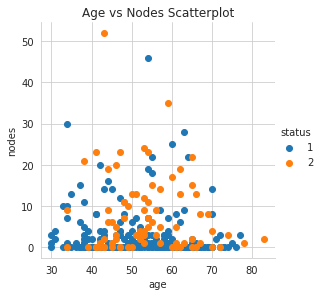

In [18]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="status", height=4) \
   .map(plt.scatter, "age", "nodes") \
   .add_legend();
plt.title('Age vs Nodes Scatterplot')
plt.show();

>**Note:**
>
>Since the no. of nodes can provide some indication on the status of patient, let's compare nodes vs age (current feature of interest). However, there is no apparent trend/relationship.

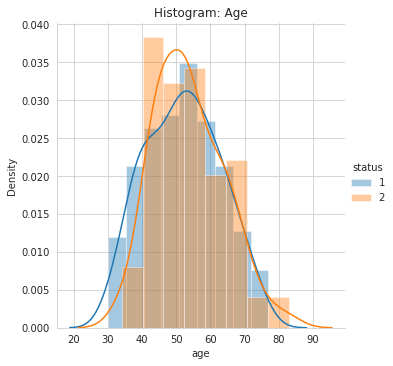

In [19]:
sns.FacetGrid(df, hue="status", height=5) \
   .map(sns.distplot, "age") \
   .add_legend();
plt.title('Histogram: Age')
plt.show();

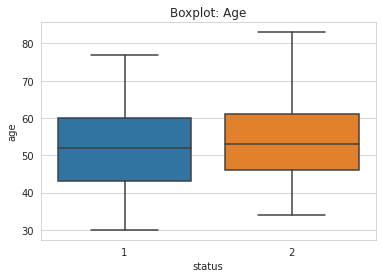

In [20]:
sns.boxplot(x='status',y='age', data=df)
plt.title('Boxplot: Age')
plt.show()

In [21]:
# as the range of possible patient age is wide, create new categorical column with 4 groups for age to simplify visualisation
df['age_group'] = df['age'].apply(lambda x: '30-40' if x <41 else ('41-50' if x<51 else ('51-60' if x<61 else '>60')))
df.tail()

,age,year,nodes,status,nodes_group,age_group
301,75,62,1,1,1-4,>60
302,76,67,0,1,0,>60
303,77,65,3,1,1-4,>60
304,78,65,1,2,1-4,>60
305,83,58,2,2,1-4,>60


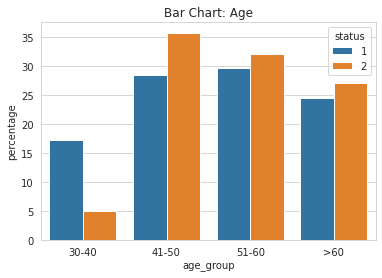

In [22]:
# as the no. of data points for status of 1 is close to 3x more than the no. of points for status of 2, use percentage instead of actual counts
temp_age = (df.groupby(['status'])['age_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('age_group'))
p = sns.barplot(x="age_group", y="percentage", hue="status", data=temp_age)
plt.title('Bar Chart: Age')
plt.show();

In [23]:
df.groupby(['status']).agg({'age':['mean','median','std','mad','min','max','count', lambda x: pd.Series.mode(x)[0]]}) 
# last column represents mode (referred here: https://stackoverflow.com/questions/57604765/mode-returns-exception-must-produce-aggregated-value)

age                                                     
             mean median        std       mad min max count <lambda_0>
status                                                                
1       52.017778     52  11.012154  9.129600  30  77   225         50
2       53.679012     53  10.167137  8.137174  34  83    81         53

>**Observations for Age:**
>
>1. The overall distribution is close to symmetrical. Both histogram and boxplot suggests similiar distributions for patients of both statuses.
2. Patients with status of 2 tend to be older than patients of status 1, although the relationship is not strong. Statistical measures between the 2 groups (e.g. mean, median) are not signficantly different.
3. Age doesn't appear to be useful in identifying status of patient.

<h3>(5) Year of Operation: Detailed Analysis</h3>

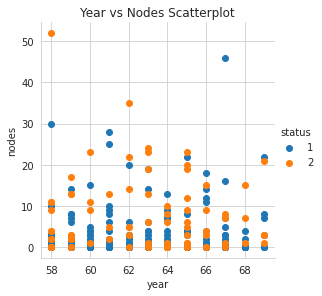

In [24]:
sns.set_style("whitegrid");
sns.FacetGrid(df, hue="status", height=4) \
   .map(plt.scatter, "year", "nodes") \
   .add_legend();
plt.title('Year vs Nodes Scatterplot')
plt.show();

>**Note:**
>
>Since the no. of nodes can provide some indication on the status of patient, let's compare nodes vs year (current feature of interest). However, there is no apparent trend/relationship.

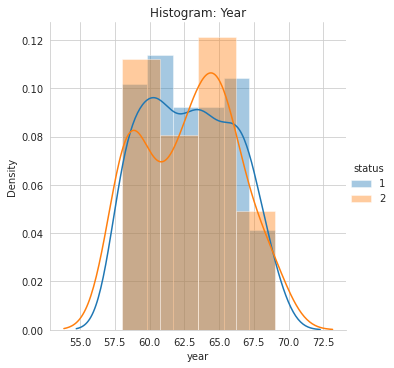

In [25]:
sns.FacetGrid(df, hue="status", height=5) \
   .map(sns.distplot, "year") \
   .add_legend();
plt.title('Histogram: Year')
plt.show();

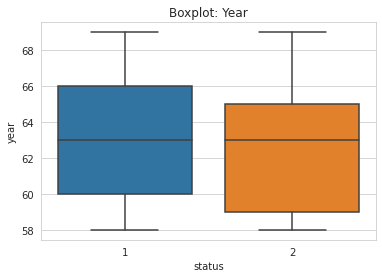

In [26]:
sns.boxplot(x='status',y='year', data=df)
plt.title('Boxplot: Year')
plt.show()

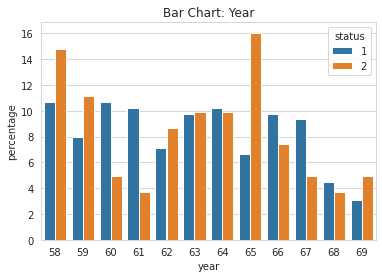

In [27]:
# as the no. of data points for status of 1 is close to 3x more than the no. of points for status of 2, use percentage instead of actual counts
temp_year = (df.groupby(['status'])['year']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('year'))
p = sns.barplot(x="year", y="percentage", hue="status", data=temp_year)
plt.title('Bar Chart: Year')
plt.show();

In [28]:
df.groupby(['status']).agg({'year':['mean','median','std','mad','min','max','count',lambda x: pd.Series.mode(x)[0]]})
# last column represents mode (referred here: https://stackoverflow.com/questions/57604765/mode-returns-exception-must-produce-aggregated-value)

year                                                    
             mean median       std       mad min max count <lambda_0>
status                                                               
1       62.862222     63  3.222915  2.769185  58  69   225         58
2       62.827160     63  3.342118  2.838287  58  69    81         65

>**Observations for Year:**
>
>1. The distributions for patients of both statuses are similiar, except that there are 2 peaks in the distribution for patients with status of 2.
2. Statistical measures between the 2 groups (e.g. mean, median) are not signficantly different.
3. A high percentage of patients with status of 2 had their operations in 1958 and 1965 (2 obvious spikes in charts).
4. Year doesn't appear to be useful in identifying status of patient.